In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [40]:
def graph_data(data):
    x_label = data.columns[0]
    y_label = data.columns[1]
    plt.plot(data[x_label], data[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [41]:
def format_pd(data, feature):
    data = data.dropna()
    # Arranca en t = 0
    print(data["t"].iloc[0])
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    try:
        data = data[["t", feature]]
    except KeyError:
        data = data[["t", "θ"]]
    return data

In [42]:
def get_tita0(data):
    try:
        return data["θr"].iloc[0]
    except KeyError:
        return data["θ"].iloc[0]

def get_amplitud(data):  # asumo amplitud como Asen(θ)
    try:
        return (max(data["θr"]) - min(data["θr"])) / 2
    except KeyError:
        return (max(data["θ"]) - min(data["θ"])) / 2

def get_periodo(data):
    try:
        # Localizo un máximo y un mínimo
        maximo = data["θ"].idxmax()
        minimo = data["θ"].idxmin()
        # Calculo el periodo
        return (data["t"].iloc[maximo] - data["t"].iloc[minimo]) * 2 # *2 porque es de pico a pico
    except KeyError:
        # Localizo un máximo y un mínimo
        maximo = data["θr"].idxmax()
        minimo = data["θr"].idxmin()
        # Calculo el periodo
        return (data["t"].iloc[maximo] - data["t"].iloc[minimo]) * 2 # *2 porque es de pico a pico

def get_frecuencia(data):
    return 1 / get_periodo(data) # NO está en rad/sec, está en Hz

0: oro l1\35cm.csv
0.834


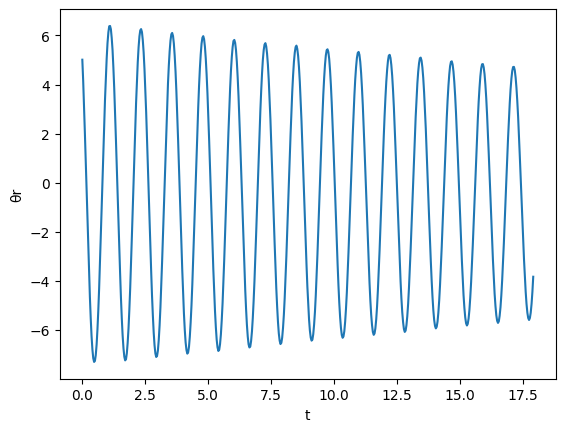

tita0: 5.013
amplitud: 6.848
periodo: 1.2679999999999996
frecuencia: 0.7886435331230287
1: oro l1\oro40.csv
2.436


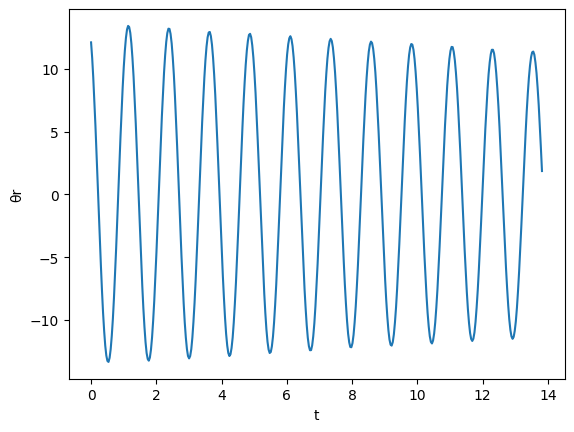

tita0: 12.11
amplitud: 13.379999999999999
periodo: 1.202
frecuencia: 0.831946755407654
2: oro l1\oro45.csv
1.101


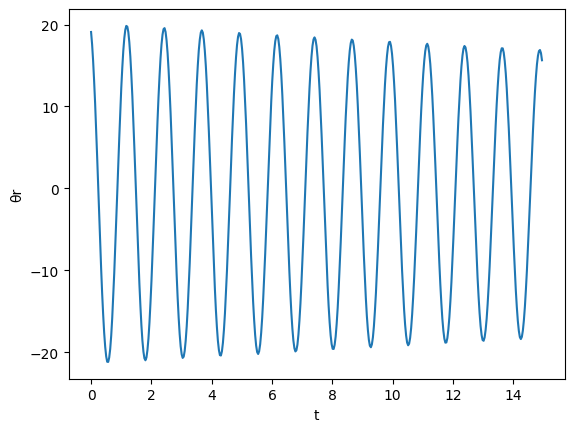

tita0: 19.09
amplitud: 20.5
periodo: 1.2000000000000002
frecuencia: 0.8333333333333333
3: oro l1\oro50.csv
1.635


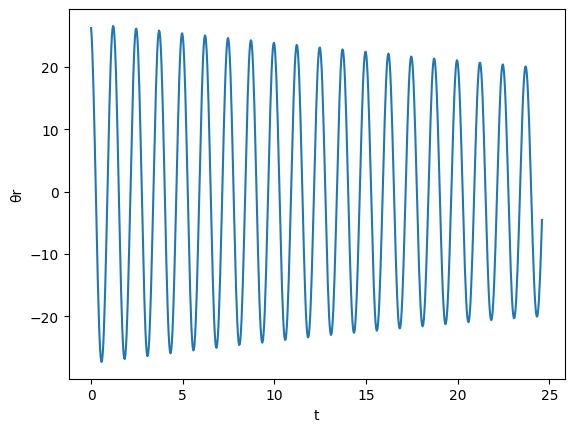

tita0: 26.2
amplitud: 26.91
periodo: 1.2680000000000007
frecuencia: 0.7886435331230279
4: plata l1\plata35.csv
1.034


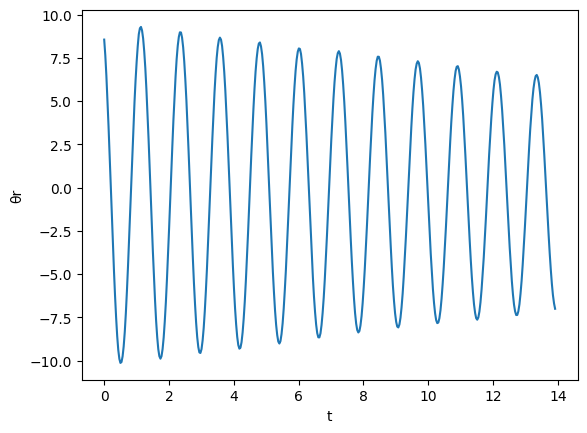

tita0: 8.562
amplitud: 9.7125
periodo: 1.2680000000000002
frecuencia: 0.7886435331230283
5: plata l1\plata40.csv
1.769


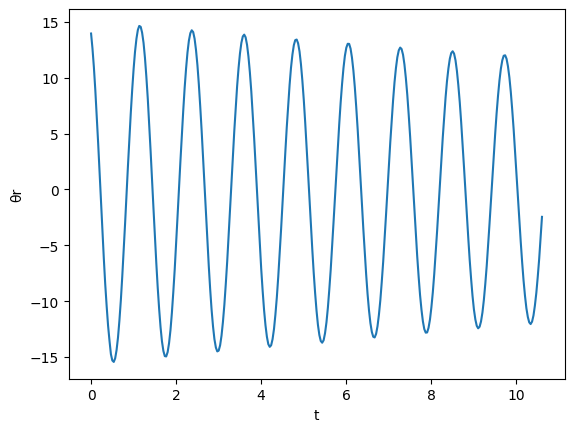

tita0: 13.96
amplitud: 15.04
periodo: 1.2000000000000002
frecuencia: 0.8333333333333333
6: plata l1\plata45.csv
1.268


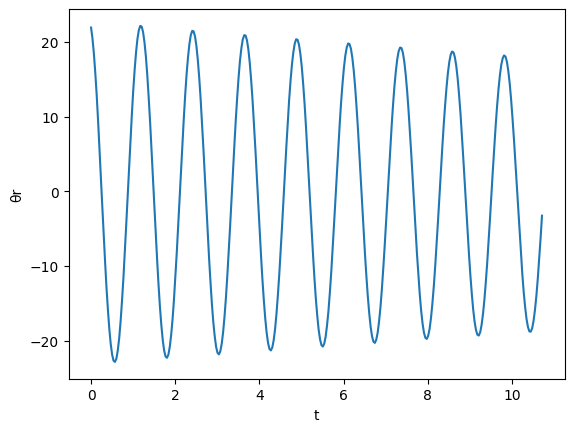

tita0: 21.92
amplitud: 22.495
periodo: 1.202
frecuencia: 0.831946755407654
7: plata l1\plata50.csv
1.669


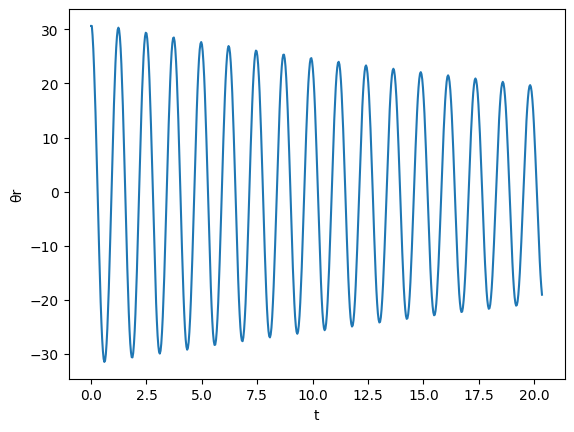

tita0: 30.63
amplitud: 31.04
periodo: -1.2000000000000002
frecuencia: -0.8333333333333333
8: plata l2\35cm.csv
1.601667


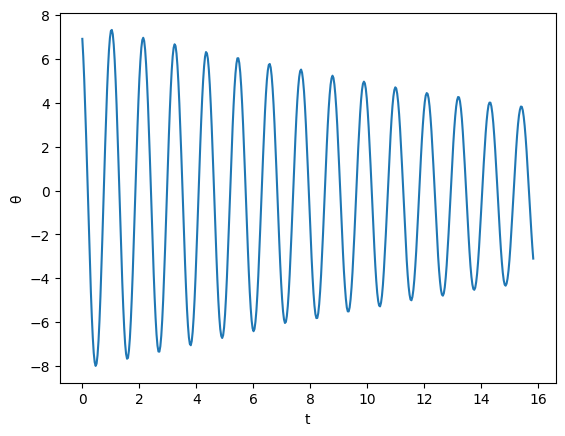

tita0: 6.907937
amplitud: 7.6523845
periodo: 1.1366680000000002
frecuencia: 0.8797643639127695
9: plata l2\40cm.csv
2.069


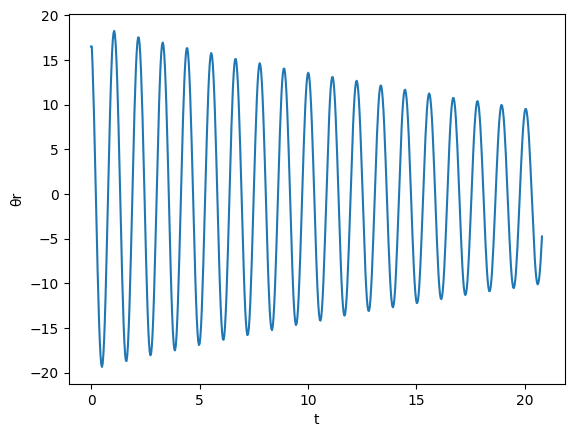

tita0: 16.52
amplitud: 18.805
periodo: 1.1340000000000003
frecuencia: 0.8818342151675482
10: plata l2\45cm.csv
0.768


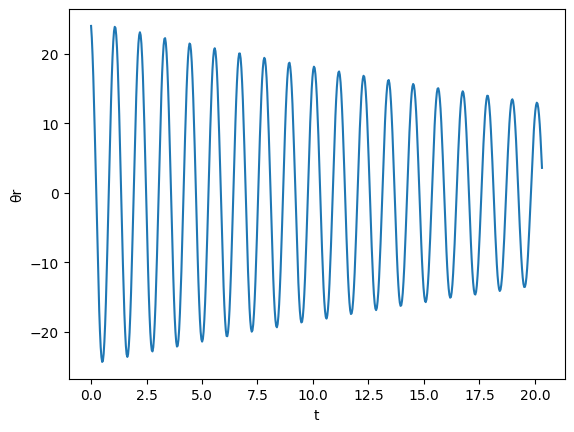

tita0: 24.01
amplitud: 24.16
periodo: -1.0
frecuencia: -1.0
11: plata l2\50cm.csv
1.669


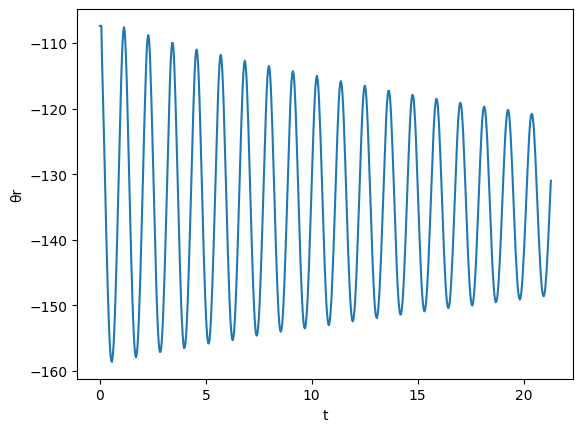

tita0: -107.4
amplitud: 25.599999999999994
periodo: -1.1340000000000003
frecuencia: -0.8818342151675482
12: plata l3\sesuponeq45peroconsuertees43.csv
1.335


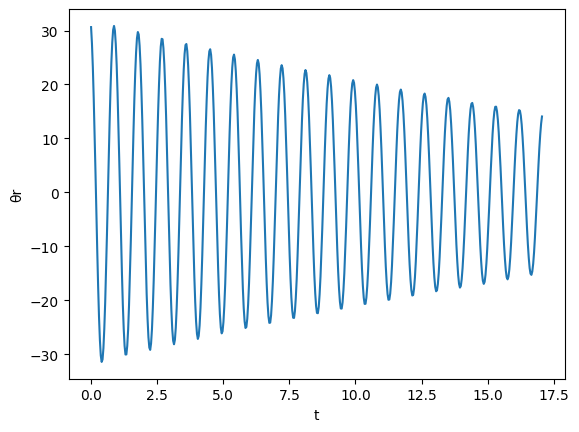

tita0: 30.63
amplitud: 31.125
periodo: 0.9359999999999995
frecuencia: 1.068376068376069
13: plata l3\sesuponeq50peroesconsuerte46.csv
2.203


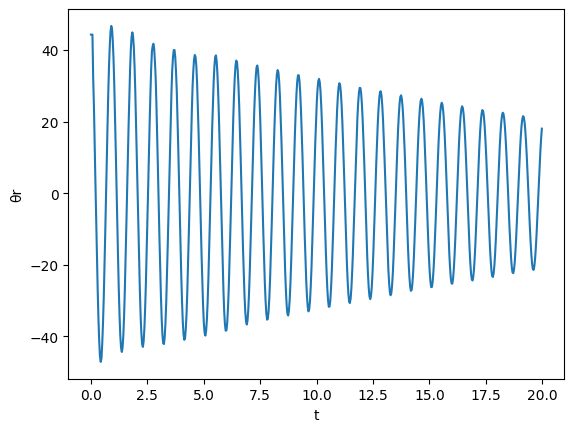

tita0: 44.29
amplitud: 46.91
periodo: 0.9359999999999999
frecuencia: 1.0683760683760684


In [43]:
import os
import pandas as pd

# Adjust the input directory path to go up one level from the current directory
input_dir = os.path.join('..', 'datasets')

datasets = []

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                # Add dataset to the list with subfolder and folder
                datasets.append(os.path.join(folder, file))

for i, dataset in enumerate(datasets):
    print(f"{i}: {dataset}")
    # Load a specific dataset into a DataFrame
    DATASET_CHOSEN = i
    data = pd.read_csv(os.path.join(input_dir, datasets[DATASET_CHOSEN]))
    data = format_pd(data, "θr")
    graph_data(data)
    print(f"tita0: {get_tita0(data)}")
    print(f"amplitud: {get_amplitud(data)}")
    print(f"periodo: {get_periodo(data)}")
    print(f"frecuencia: {get_frecuencia(data)}")
